Project Title

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta

import yfinance as yf

import scipy.stats as stats
from scipy.optimize import brentq

In [193]:
TICKER = "AAPL" # Apple Inc.
RISK_FREE_RATE = 0.04  # 4% annual risk-free rate
DIVIDEND_YIELD = 0.006  # 0.6% annual dividend yield
NUM_SIMULATIONS = 10000  # Number of Monte Carlo simulations
T_YEARS = 5  # Time horizon in years
T_DAYS = T_YEARS * 252  # Trading days in T years


print(" All libraries imported successfully")
print(f" Using ticker: {TICKER}")
print(f" Risk-free rate: {RISK_FREE_RATE*100:.2f}%")
print(f" Dividend yield: {DIVIDEND_YIELD*100:.2f}%")
print(f" Number of simulations: {NUM_SIMULATIONS}")

 All libraries imported successfully
 Using ticker: AAPL
 Risk-free rate: 4.00%
 Dividend yield: 0.60%
 Number of simulations: 10000


In [194]:
# ============================================================================
# PHASE 1: HISTORICAL VOLATILITY ANALYSIS
# ============================================================================
# SECTION 1: DATA COLLECTION
# ============================================================================

def download_stock_data(ticker, start_date, end_date):
    """
    Parameters:
    -----------
    ticker : str
        Stock ticker (e.g., 'SPY')
    start_date : str
        Start date 'YYYY-MM-DD'
    end_date : str
        End date 'YYYY-MM-DD'
    
    Returns:
    --------
    pd.DataFrame : Stock data with columns [Open, High, Low, Close, Adj Close, Volume]
    """
    #Download data using yfinance
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)

    return data
    
ticker = TICKER  

end_date = datetime.now() 
start_date = end_date - timedelta(days = 365*5 +1)  #Calculate 5 years before end_date
print(type(end_date))
# Download stock data
stock_data = download_stock_data(ticker, 
                                 start_date.strftime('%Y-%m-%d'),
                                 end_date.strftime('%Y-%m-%d')
)
print(f"\n Downloaded {len(stock_data)} days of data")

<class 'datetime.datetime'>

 Downloaded 1255 days of data


/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/3826346025.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)


In [196]:
# ============================================================================
# SECTION 2: CALCULATE RETURNS
# ============================================================================

def calculate_returns(prices):
    """
    Calculate log returns from price series
    
    Parameters:
    -----------
    prices : pd.Series
        Price series
    
    Returns:
    --------
    pd.Series : Log returns
    """
    
    
    if isinstance(prices, pd.DataFrame):
        prices = prices.squeeze()

    #calculate log returns
    returns = np.log(prices/prices.shift(1))

    return returns.dropna()


# Calculate returns from adjusted close prices
if 'Adj Close' in stock_data.columns:
    prices = stock_data['Adj Close']
    print("Using 'Adjusted Close' prices ")
else:
    prices = stock_data['Close']
    print("'Adjusted Close' data not found.. Using 'Close' values instead ")


returns = calculate_returns(prices)

print(f"\nReturns calculated: {len(returns)} data points")
print(f"Mean return: {returns.mean():.4%}")
print(f"Std return: {returns.std():.4%}")

'Adjusted Close' data not found.. Using 'Close' values instead 

Returns calculated: 1254 data points
Mean return: 0.0692%
Std return: 1.7663%


In [197]:
# ============================================================================
# SECTION 3: REALIZED VOLATILITY
# ============================================================================

def realized_volatility(returns, window, annualize=True):
    """
    Calculate realized (historical) volatility over rolling windows
   
    Parameters:
    -----------
    returns : pd.Series
        Return series
    window : int
        Rolling window size in days
    annualize : bool
        Whether to annualize the volatility (default: True)
    
    Returns:
    --------
    pd.Series : Rolling realized volatility
    """    
    # Calculate rolling standard deviation
    vol = returns.rolling(window=window).std()

    if annualize:
        vol = vol * np.sqrt(252)

    return vol


print("\nCalculating realized volatility...")

# Calculate volatility for multiple windows
windows = [7, 10, 20, 30, 60, 90, 120]  
volatilities = {}  # Dictionary to store results

for window in windows:
    volatilities[f'{window}d'] = realized_volatility(returns, window)
    
# Create DataFrame from volatilities dictionary
vol_df = pd.DataFrame(volatilities).dropna()  

print(vol_df.head())
print(f" Volatility calculations complete!")


Calculating realized volatility...
                  7d       10d       20d       30d       60d       90d  \
Date                                                                     
2021-05-04  0.233776  0.233855  0.248881  0.232735  0.291442  0.306495   
2021-05-05  0.232012  0.233095  0.244448  0.231470  0.291475  0.306309   
2021-05-06  0.261088  0.242854  0.238901  0.224233  0.292608  0.306793   
2021-05-07  0.268036  0.221798  0.227771  0.224329  0.292763  0.301079   
2021-05-10  0.298976  0.246819  0.241144  0.239106  0.297394  0.303370   

                120d  
Date                  
2021-05-04  0.296166  
2021-05-05  0.296118  
2021-05-06  0.293583  
2021-05-07  0.293625  
2021-05-10  0.296202  
 Volatility calculations complete!


In [198]:
# ============================================================================
# SECTION 4: VOLATILITY CONE CONSTRUCTION
# ============================================================================

def build_volatility_cone(returns, windows=[7, 10, 20, 30, 60, 90, 120]):
    """
    Build a volatility cone showing percentile distributions

    Parameters:
    -----------
    returns : pd.Series
        Return series
    windows : list
        List of window sizes to analyze
    
    Returns:
    --------
    pd.DataFrame : Volatility cone data with columns:
        - window: window size
        - min, 5th, 10th, 25th, median, 75th, 90th, 95th, max: percentiles
        - current: current volatility
        - mean, std: statistics
    """
    
    cone_data = []  # List to store results for each window

    # Loop through each window:
    for window in windows:
        
        vol = realized_volatility(returns, window).dropna()
        percentiles = {
            'window': window,
            'min': vol.min(),
            '10th': vol.quantile(0.10),
            '25th': vol.quantile(0.25),
            'median': vol.median(),
            '75th': vol.quantile(0.75),
            '90th': vol.quantile(0.90),
            'max': vol.max(),
            'current': vol.iloc[-1],
            'mean': vol.mean(),
            'std': vol.std()
        }

        # Append to cone_data list
        cone_data.append(percentiles)
        

    # Convert list of dictionaries to DataFrame
    return pd.DataFrame(cone_data)

print("\nBuilding Volatility Cone...")
cone = build_volatility_cone(returns)  

print("\n" + "="*70)
print("VOLATILITY CONE DATA")
print("="*70)
print(cone.to_string(index=False))


Building Volatility Cone...

VOLATILITY CONE DATA
 window      min     10th     25th   median     75th     90th      max  current     mean      std
      7 0.054297 0.121813 0.164120 0.221554 0.306149 0.397768 1.309367 0.064478 0.249863 0.131026
     10 0.057860 0.138280 0.175999 0.234923 0.307057 0.390468 1.097187 0.131130 0.255452 0.120977
     20 0.094093 0.153003 0.194866 0.243868 0.305327 0.373538 0.803400 0.235387 0.262449 0.104858
     30 0.125278 0.168728 0.198909 0.248991 0.300794 0.368179 0.688308 0.202136 0.265155 0.097287
     60 0.138448 0.181205 0.204359 0.243778 0.303266 0.402331 0.522883 0.226977 0.268941 0.086024
     90 0.168808 0.190469 0.204401 0.249272 0.327869 0.380482 0.459002 0.234907 0.271075 0.078096
    120 0.173227 0.195132 0.206786 0.251977 0.352822 0.378284 0.408860 0.229278 0.273053 0.071718


In [199]:
# ============================================================================
# SECTION 5: ANALYSIS
# ============================================================================

def analyze_current_volatility(cone_df):
    """
    Analyze where current volatility sits relative to history
    
    Parameters:
    -----------
    cone_df : pd.DataFrame
        Volatility cone data
    """
    
    print("\n" + "="*70)
    print("CURRENT VOLATILITY ANALYSIS")
    print("="*70)
    
    # Loop through each row in cone_df:
    for i, row in cone_df.iterrows():
        # Get values from the row
        window = row['window']
        current = row['current']
        p25 = row['25th']
        p75 = row['75th']
        median = row['median']
        
        # Determine if volatility is LOW, MEDIUM, or HIGH
        if current < p25:
            level = "LOW"
            signal = "Consider BUYING options"
        elif current > p75:
            level = "HIGH"  
            signal = "Consider SELLING options"
        else:
            level = "MEDIUM"
            signal = "No strong signal"
        
        # Print the analysis
        print(f"\n{window}-day window:")
        print(f"  Current: {current:.2%}")
        print(f"  Median:  {median:.2%}")
        print(f"  Level:   {level}")
        print(f"  Signal:  {signal}")
        
    
    print("\n" + "="*70)


# Run the analysis
analyze_current_volatility(cone)



CURRENT VOLATILITY ANALYSIS

7.0-day window:
  Current: 6.45%
  Median:  22.16%
  Level:   LOW
  Signal:  Consider BUYING options

10.0-day window:
  Current: 13.11%
  Median:  23.49%
  Level:   LOW
  Signal:  Consider BUYING options

20.0-day window:
  Current: 23.54%
  Median:  24.39%
  Level:   MEDIUM
  Signal:  No strong signal

30.0-day window:
  Current: 20.21%
  Median:  24.90%
  Level:   MEDIUM
  Signal:  No strong signal

60.0-day window:
  Current: 22.70%
  Median:  24.38%
  Level:   MEDIUM
  Signal:  No strong signal

90.0-day window:
  Current: 23.49%
  Median:  24.93%
  Level:   MEDIUM
  Signal:  No strong signal

120.0-day window:
  Current: 22.93%
  Median:  25.20%
  Level:   MEDIUM
  Signal:  No strong signal



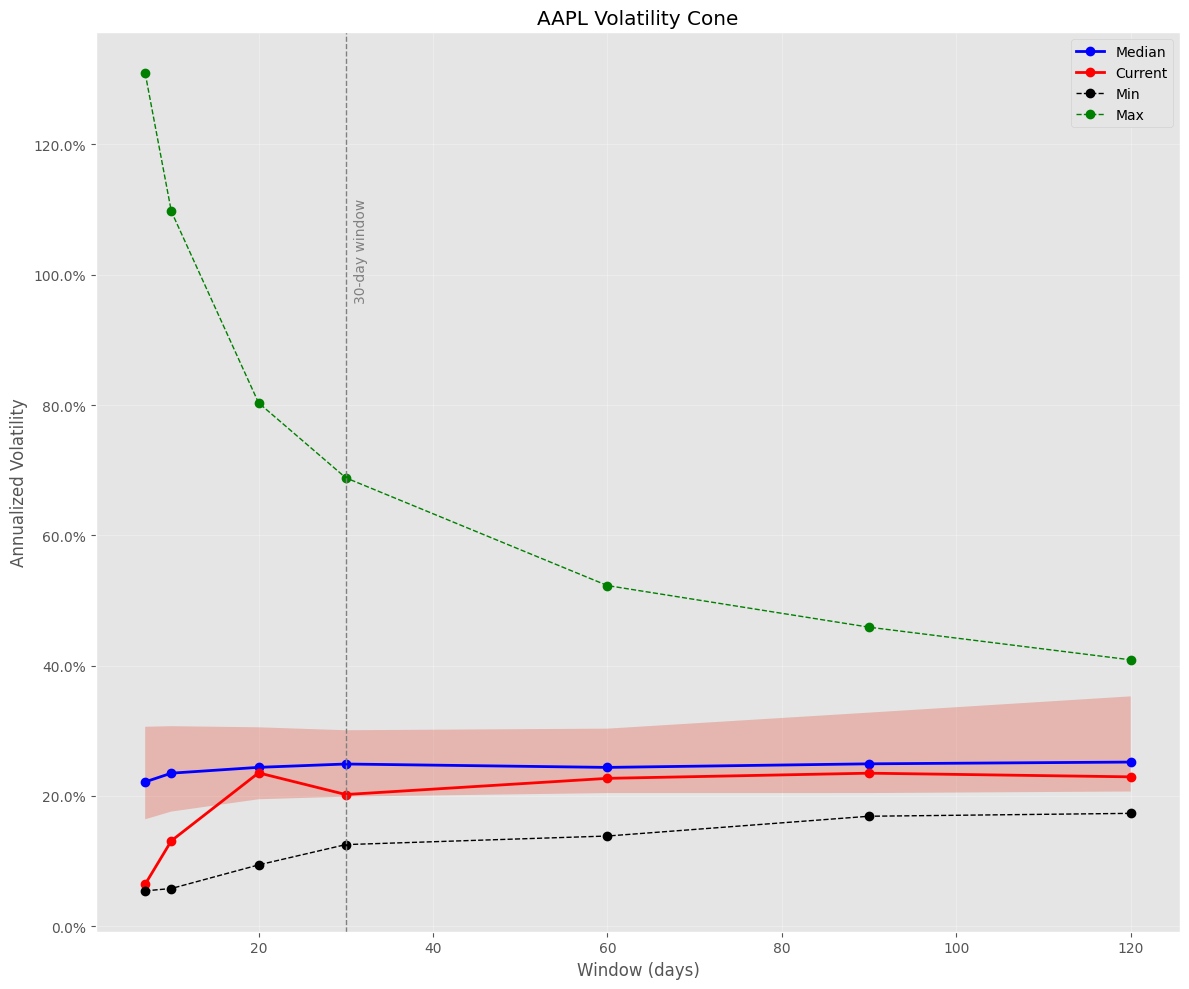


Volatility cone plot saved!


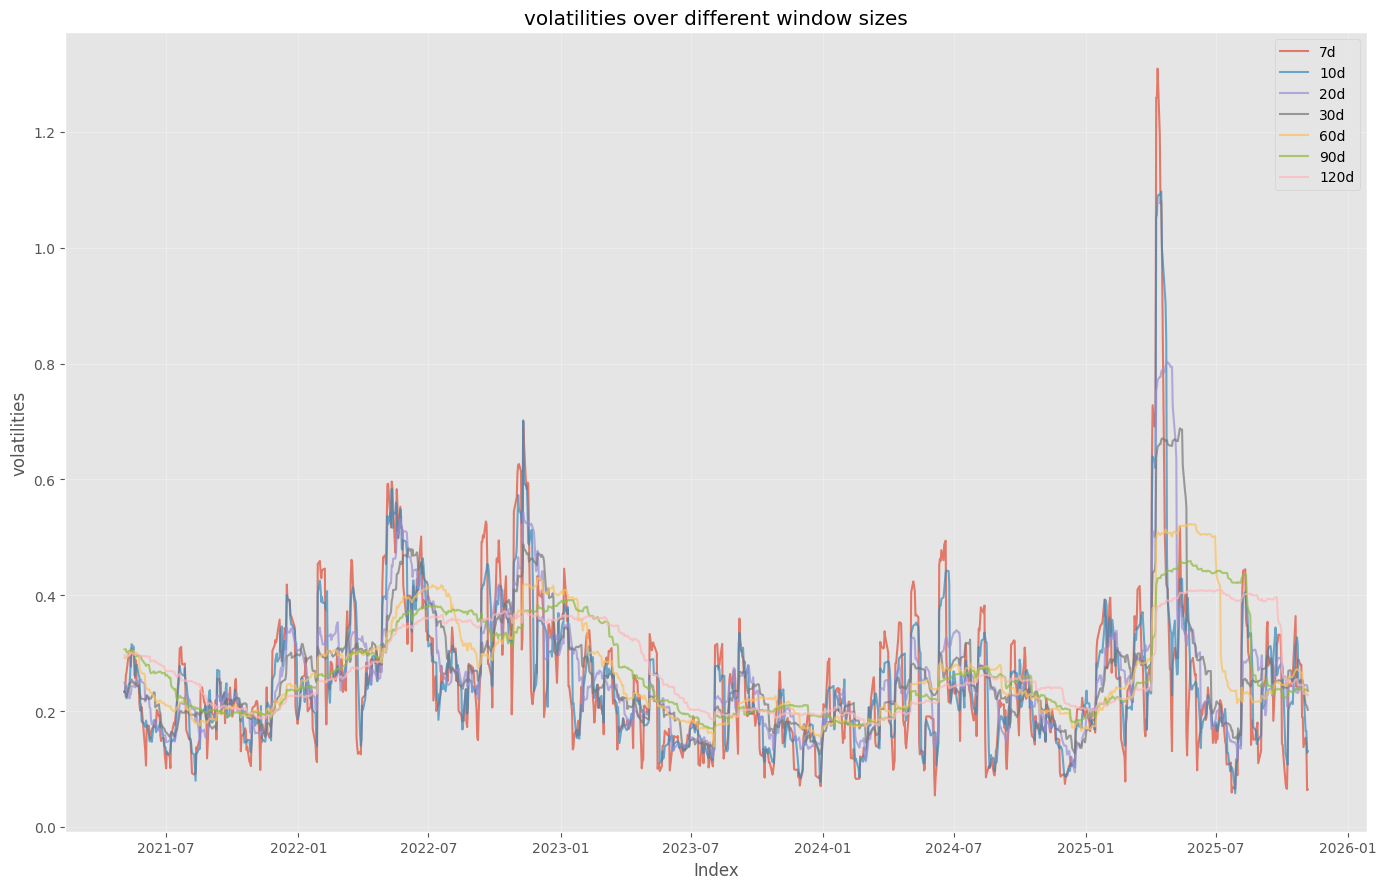

Time series plot saved!


In [200]:
# ============================================================================
# SECTION 6: VISUALIZATIONS
# ============================================================================

def plot_volatility_cone(cone_df, ticker):
    """
    Create volatility cone visualization
    Parameters:
    -----------
    cone_df : pd.DataFrame
        Volatility cone data
    ticker : str
        Stock ticker
    """
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Get the data
    windows = np.array(cone_df['window'], dtype=float)   

    # Create filled areas 
    ax.fill_between(windows, 
            np.array(cone_df['25th']), 
            np.array(cone_df['75th']), 
            alpha=0.3)
    
    # Plot median line
    ax.plot(windows, np.array(cone_df['median']), 'bo-', linewidth=2, label='Median')

    # Plot current volatility line
    ax.plot(windows, np.array(cone_df['current']), 'ro-', linewidth=2, label='Current')

    #plot min and max lines
    ax.plot(windows, np.array(cone_df['min']), 'ko--', linewidth=1, label='Min')
    ax.plot(windows, np.array(cone_df['max']), 'go--', linewidth=1, label='Max')

    #make vertical window at x=30
    ax.axvline(x=30, color='gray', linestyle='--', linewidth=1) 
    #Annotate the vertical line
    ax.text(31, ax.get_ylim()[1]*0.7, '30-day window', rotation=90, color='gray')
    

    # Add labels and title
    ax.set_xlabel('Window (days)')
    ax.set_ylabel('Annualized Volatility')
    ax.set_title(f'{ticker} Volatility Cone')
    
    # Add legend and grid
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Format y-axis as percentage
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    
    plt.tight_layout()
    plt.savefig('volatility_cone.png', dpi=300)
    plt.show()
    
    print("\nVolatility cone plot saved!")



def plot_volatility_time_series(vol_df, ticker):
    """
    Plot volatility over time for different windows
    
    TODO #13: Implement this function
    
    Create a line plot showing how volatility evolved over time
    for different window sizes
    """
    
    fig, ax = plt.subplots(figsize=(14, 9))

    # Loop through each column in vol_df and plot it
    for col in vol_df.columns:
        ax.plot(vol_df.index, vol_df[col], label=col, alpha=0.7)
    
    # Add labels, title, legend, grid
    ax.set_xlabel("Index")
    ax.set_ylabel("volatilities")
    ax.set_title("volatilities over different window sizes")

    ax.legend()
    ax.grid(True, alpha = 0.3)

    plt.tight_layout()
    plt.savefig('volatility_time_series.png', dpi=300)
    plt.show()
    
    print("Time series plot saved!")

cone = cone.apply(pd.to_numeric, errors='coerce')
cone = cone.dropna(subset=['25th', '75th', 'median'])

# Create the visualizations
plot_volatility_cone(cone, ticker)
plot_volatility_time_series(vol_df, ticker)


In [154]:
# ============================================================================
# SECTION 7: SAVE DATA
# ============================================================================

# TODO #15: Save your data for future phases
vol_df.to_csv('realized_volatility.csv')
cone.to_csv('volatility_cone.csv')
stock_data.to_csv('stock_data.csv')

print("\n Data saved for next phases!")


 Data saved for next phases!


In [201]:
# ===========================================================================
# PHASE 2: IMPLIED VOLATILITY EXTRACTION
# ===========================================================================
# SECTION 8 : GET CURRENT STOCK PRICE & OPTIONS DATA
# ============================================================================

def black_scholes(S, K, T, r, sigma, option_type='call'):
    """
    Black-Scholes option pricing formula
    
    Parameters:
    -----------
    S : float
        Current stock price
    K : float
        Strike price
    T : float
        Time to expiration (years)
    r : float
        Risk-free interest rate (annual)
    sigma : float
        Volatility (annual)
    option_type : str
        'call' or 'put'
    
    Returns:
    --------
    price : float
        Option price
    """
    
    # Calculate d1
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    
    # Calculate d2
    d2 = d1 - sigma * np.sqrt(T)

    # Calculate option price
    call = S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)
    put = K * np.exp(-r * T) * stats.norm.cdf(-d2) - S * stats.norm.cdf(-d1)

    if option_type == 'call':
        return call
    else:
        return put

# Test Black-Scholes
test_price = black_scholes(S=100, K=100, T=1.0, r=0.05, sigma=0.20, option_type='call')
print(f"\nTest BS price: ${test_price:.2f}")
print("Expected: ~$10.45")

# Verify put-call parity
call_test = black_scholes(S=100, K=100, T=1.0, r=0.05, sigma=0.20, option_type='call')
put_test = black_scholes(S=100, K=100, T=1.0, r=0.05, sigma=0.20, option_type='put')
parity_diff = call_test - put_test
theoretical_diff = 100 - 100 * np.exp(-0.05 * 1.0)
print(f"Put-Call Parity Difference: {parity_diff:.2f}, Theoretical: {theoretical_diff:.2f}")


Test BS price: $10.45
Expected: ~$10.45
Put-Call Parity Difference: 4.88, Theoretical: 4.88


In [202]:
# ===========================================================================
# SECTION 9 : IMPLEMENT IMPLIED VOLATILITY CALCULATION
# =============================================================================

def implied_volatility(market_price, S, K, T, r, option_type='call', sigma_bounds=(1e-6, 1.0)):
    """
    Calculate implied volatility using Brent's method
    
    Parameters:
    -----------
    market_price : float
        Observed market price of option
    S, K, T, r : float
        Black-Scholes parameters
    option_type : str
        'call' or 'put'
    sigma_bounds : tuple
        (min_sigma, max_sigma) search bounds
    
    Returns:
    --------
    sigma : float
        Implied volatility (or np.nan if no convergence)
    """
    
    # Define objective function
    def _objective(sigma):
        return black_scholes(S, K, T, r, sigma, option_type) - market_price
    try:
        return brentq(_objective, sigma_bounds[0], sigma_bounds[1]) # Use brentq to find implied volatility
    except ValueError:
        return np.nan

# Test implied volatility
iv = implied_volatility(market_price=10.45, S=100, K=100, T=1.0, r=0.05, option_type='call')
print(f"\nImplied volatility: {iv:.2%}")
print("Expected: ~20%")

# Verify by pricing back
verified_price = black_scholes(100, 100, 1.0, 0.05, iv, 'call')
print(f"Verification: ${verified_price:.2f} (should be ~$10.45)")


Implied volatility: 20.00%
Expected: ~20%
Verification: $10.45 (should be ~$10.45)


In [204]:
# ===========================================================================
# SECTION 10 : GET CURRENT STOCK PRICE & OPTIONS DATA
# =============================================================================

def get_current_price(ticker):
    """
    Get current stock price
    
    Parameters:
    -----------
    ticker : str
        Stock ticker
    
    Returns:
    --------
    float : Current stock price
    """
    
    ticker_obj = yf.Ticker(ticker)

    return ticker_obj.info['currentPrice']

def download_option_chain(ticker, expiration_date=None):
    """
    Download option chain for a given ticker
   
    Parameters:
    -----------
    ticker : str
        Stock ticker
    expiration_date : str, optional
        Expiration date in 'YYYY-MM-DD' format
    
    Returns:
    --------
    tuple : (calls_df, puts_df, expiration_date, days_to_expiry)
    """

    #Create Ticker object and get expiration dates
    ticker_obj = yf.Ticker(ticker)
    expirations = ticker_obj.options  
    print(f"Available expiration dates: {expirations[:3]}")

    if expiration_date is None:
        expiration_date = expirations[0]  # Use first available date

    #Download option chain
    chain = ticker_obj.option_chain(expiration_date)
    calls = chain.calls
    puts = chain.puts

    # Calculate days, years to expiration
    T_days = (pd.to_datetime(expiration_date) - pd.Timestamp.now()).days 
    T_years = T_days / 365

    return (calls, puts, expirations, T_days, T_years)

# Download option data
ticker = TICKER

print("\nDownloading option data...")

# Get current price 
current_price = get_current_price(ticker)

# Download option chain
calls, puts, expirations, days_to_expiry, years_to_expiry = download_option_chain(ticker)

print(f"Current {ticker} price: ${current_price:.2f}")
print(f"Option expiration: {expirations[0]} ({days_to_expiry} days)")
print(f"Option expiration: {expirations[0]} ({years_to_expiry} years)")
print(f"Downloaded {len(calls)} call options")
print(f"Downloaded {len(puts)} put options")



Available expiration dates: ('2025-11-14', '2025-11-21', '2025-11-28')
Current AAPL price: $268.47
Option expiration: 2025-11-14 (6 days)
Option expiration: 2025-11-14 (0.01643835616438356 years)
Downloaded 69 call options
Downloaded 57 put options


In [158]:
# ===========================================================================
# SECTION 11 : EXTRACT MARKET IMPLIED VOLATILITY
# =============================================================================

def extract_implied_volatility(expirations, calls, puts, current_price, option_type='call'):
    results = []

    #Loop through expiration dates
    for exp_date in expirations[:5]:  # Limiting to first 5 expirations for speed
        if option_type == 'put':
            options = puts
        else:
            options = calls
        for idx, row in options.iterrows():
            if row['volume'] > 0 and row['lastPrice'] > 0:
                S = current_price
                K = row["strike"]
                T = (pd.to_datetime(exp_date) - pd.Timestamp.now()).days / 365.0 
                r = 0.05  # Assume 5% risk-free rate
                market_price = row["lastPrice"]

                # Calculate implied volatility
                iv = implied_volatility(market_price, S, K, T, r, option_type='call')
                if not np.isnan(iv):
                    results.append({
                        'expiration': exp_date,
                        'strike': K,
                        'market_price': market_price,
                        'implied_volatility': iv
                    })
    return pd.DataFrame(results)

# Get market data
print("\nDownloading options data...")
current_price=get_current_price(ticker)
iv_data = extract_implied_volatility(expirations, calls, puts, current_price=current_price, option_type='call')
print(f"Extracted {len(iv_data)} option IVs")
print("\nSample:")
print(iv_data.head())

# Save IV data
iv_data.to_csv('implied_volatility_data.csv', index=False)
print("\nImplied volatility data saved!")



Extracted 139 option IVs

Sample:
   expiration  strike  market_price  implied_volatility
0  2025-11-14   270.0          0.01            0.020923
1  2025-11-14   272.5          0.01            0.051096
2  2025-11-14   275.0          0.01            0.078672
3  2025-11-14   277.5          0.01            0.104869
4  2025-11-14   280.0          0.01            0.130102

Implied volatility data saved!


/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/2491733414.py:33: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/2491733414.py:36: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)


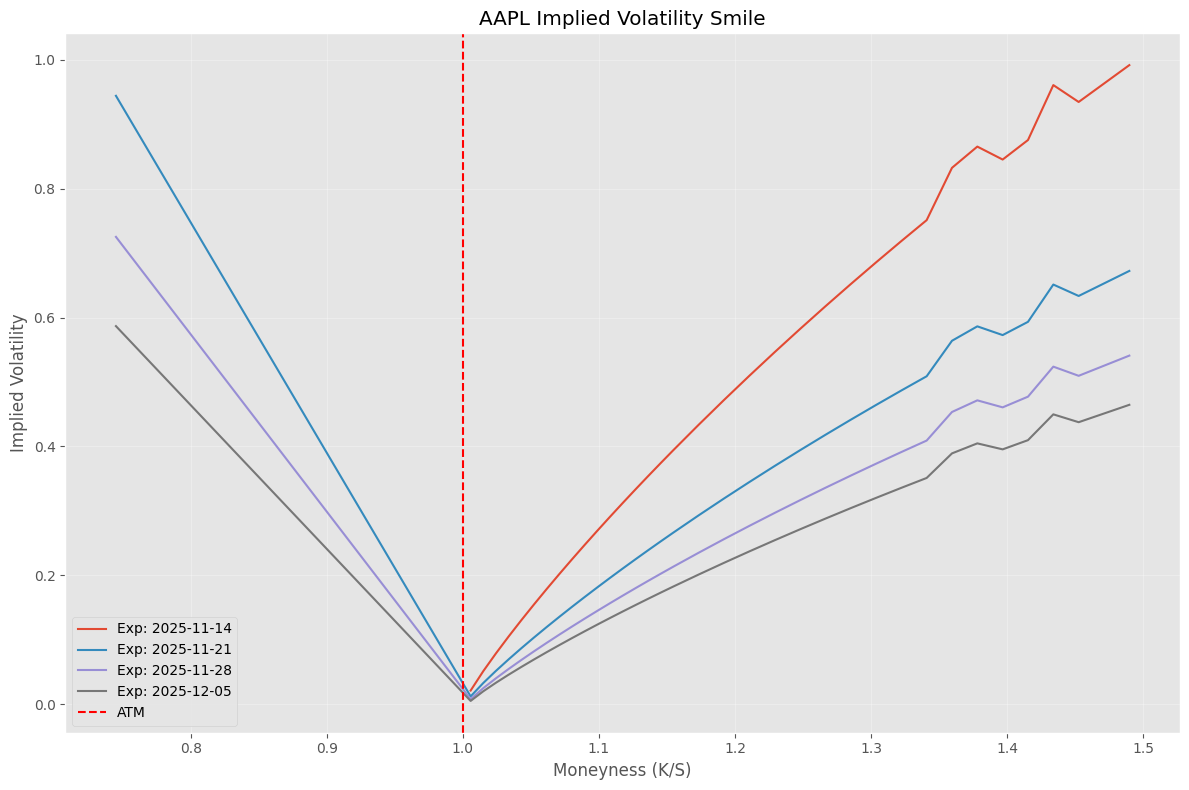

In [205]:
# ===========================================================================
# SECTION 12 : VISUALIZE VOLATILITY SMILE
# =============================================================================

def plot_volatility_smile(iv_data, S0, ticker=ticker):
    """
    Plot implied volatility vs moneyness
    
    Parameters:
    -----------
    iv_data : pd.DataFrame
        IV data with strike, expiration, implied_vol
    S0 : float
        Current stock price
    """
    
    # Add moneyness column
    iv_data['moneyness'] = iv_data['strike'] / S0

    plt.figure(figsize=(12, 8))
    
    # Plot for each unique expiration
    for exp in iv_data['expiration'].unique():
        
        # Filter data for this expiration
        subset = iv_data[iv_data['expiration'] == exp]
        # Sort by moneyness for clean lines
        subset = subset.sort_values('moneyness')

        # Plot IV vs moneyness
        plt.plot(subset['moneyness'], subset['implied_volatility'], label=f"Exp: {exp}")

    # Add labels and title
    plt.xlabel('Moneyness (K/S)')
    plt.ylabel('Implied Volatility')
    plt.title(f'{ticker} Implied Volatility Smile')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add ATM line
    plt.axvline(1.0, color='red', linestyle='--', label='ATM')

    plt.legend()
    
    # Add styling
    plt.style.use('ggplot')
    plt.tight_layout()

# Create smile plot
current_price = get_current_price(ticker)
plot_volatility_smile(iv_data, current_price)
plt.show()

In [206]:
# ===========================================================================
# PHASE 3: TRADING STRATEGIES BASED ON VOLATILITY
# ===========================================================================
# SECTION 13 : COMPARE HISTORICAL VS IMPLIED VOLATILITY
# =============================================================================

#Get ATM implied volatility
def get_atm_iv(iv_data, S):
    """
    Get at-the-money implied volatility
    
    Parameters:
    -----------
    iv_data : pd.DataFrame
        IV data with strike, implied_vol
    S : float
        Current stock price
    
    Returns:
    --------
    float : ATM implied volatility
    """
    
    # Find strike closest to current price
    iv_data['moneyness'] = iv_data['strike']/S
    iv_data['distance'] = abs(1-iv_data['moneyness'])

    atm_row = iv_data.loc[iv_data['distance'].idxmin()]

    calculated_iv = float(atm_row['implied_volatility'])
    print(f"ATM IV found for strike {atm_row['strike']}: {calculated_iv:.4f}")

    return float(atm_row['implied_volatility'])


def generate_trading_signals(atm_iv, cone_df, window = 30):
    """
    Parameters:
    -----------
    current_iv : float
        Current implied volatility
    cone_df : pd.DataFrame
        Volatility cone from Phase 1
    window : int
        Which window to compare (default 30 days)
    
    Returns:
    --------
    dict : Analysis results with signal
    """
    
    # Get the row for this window from cone
    cone_row = cone_df.loc[cone_df['window'] == window]

    if cone_row.empty:
        raise ValueError(f"No matching window {window} found in volatility cone!")

    cone_row = cone_row.iloc[0]


    # Extract percentiles and coerce to floats (defensive)
    def to_scalar(x, name):
        try:
            return float(x)
        except Exception:
            # Try common fallbacks: if it's a 1-element array/Series, extract its item
            if hasattr(x, "item"):
                try:
                    return float(x.item())
                except Exception:
                    pass
            raise ValueError(f"Could not convert {name} value to float; got type {type(x)} with value {x}")

    # Extract percentiles
    p10 = to_scalar(cone_row.get('10th', np.nan), '10th')
    p25 = to_scalar(cone_row.get('25th', np.nan), '25th')
    median = to_scalar(cone_row.get('median', np.nan), 'median')
    p75 = to_scalar(cone_row.get('75th', np.nan), '75th')
    p90 = to_scalar(cone_row.get('90th', np.nan), '90th')

     # Get current IV
    current_iv = atm_iv

    # Determine signal
    if current_iv < p25:
        level = "LOW"
        signal = "BUY OPTIONS"
        reason = "IV below 25th percentile - options are cheap"
    elif current_iv > p75:
        level = "HIGH"
        signal = "SELL OPTIONS"
        reason = "IV above 75th percentile - options are expensive"
    else:
        level = "MEDIUM"
        signal = "NEUTRAL"
        reason = "IV in normal range"
    
    return {
        'current_iv': current_iv,
        'historical_median': median,
        'level': level,
        'signal': signal,
        'reason': reason,
        'percentiles': {'10th': p10, '25th': p25, 'median': median, '75th': p75, '90th': p90}
    }


# Compare and generate signals
print("\nGenerating trading signals...")

current_price = get_current_price(ticker)
atm_iv = get_atm_iv(iv_data, current_price)  
print(f"\nATM Implied Volatility: {atm_iv:.2%}")

# Compare IV to historical for different windows
for window in [7, 10, 20, 30, 60]:
    analysis = generate_trading_signals(atm_iv, cone, window)
    
    # Print the analysis
    print(f"\n{window}-day comparison:")
    print(f"  Current IV:  {analysis['current_iv']:.2%}")
    print(f"  Historical:  {analysis['historical_median']:.2%}")
    print(f"  Assessment:  {analysis['level']}")
    print(f"  Signal:      {analysis['signal']}")
    print(f"  Reason:      {analysis['reason']}")






Generating trading signals...
ATM IV found for strike 270.0: 0.0209

ATM Implied Volatility: 2.09%

7-day comparison:
  Current IV:  2.09%
  Historical:  22.16%
  Assessment:  LOW
  Signal:      BUY OPTIONS
  Reason:      IV below 25th percentile - options are cheap

10-day comparison:
  Current IV:  2.09%
  Historical:  23.49%
  Assessment:  LOW
  Signal:      BUY OPTIONS
  Reason:      IV below 25th percentile - options are cheap

20-day comparison:
  Current IV:  2.09%
  Historical:  24.39%
  Assessment:  LOW
  Signal:      BUY OPTIONS
  Reason:      IV below 25th percentile - options are cheap

30-day comparison:
  Current IV:  2.09%
  Historical:  24.90%
  Assessment:  LOW
  Signal:      BUY OPTIONS
  Reason:      IV below 25th percentile - options are cheap

60-day comparison:
  Current IV:  2.09%
  Historical:  24.38%
  Assessment:  LOW
  Signal:      BUY OPTIONS
  Reason:      IV below 25th percentile - options are cheap


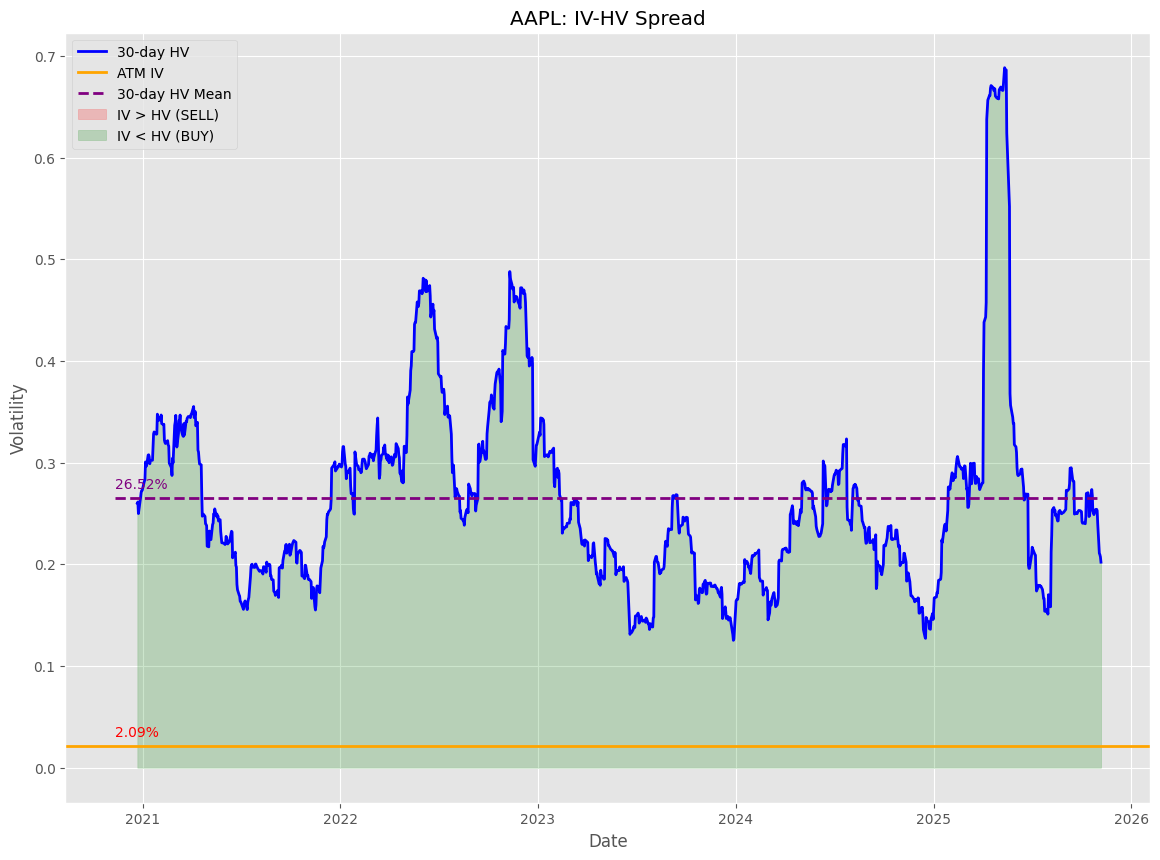

In [207]:
# ===========================================================================
# SECTION 14 : Plot IV vs HV 
# =============================================================================
# Plot IV vs HV over time
fig, ax = plt.subplots(figsize=(14, 10))

# Get 30-day HV time series
hv_30 = realized_volatility(returns, window=30)

# Plot
ax.plot(hv_30.index, hv_30.values, 'b-', label='30-day HV', linewidth=2)
ax.axhline(atm_iv, color='orange', linestyle='-', linewidth=2, label='ATM IV')
hv_mean  = hv_30.mean()
#plot hv_mean line
ax.hlines(hv_mean, xmin=hv_30.index.min(), xmax=hv_30.index.max(), colors='purple', linestyles='--', linewidth=2, label='30-day HV Mean')

#annotate hv_mean line and atm_iv line percentages
ax.text(hv_30.index.min(), hv_mean + 0.01, f"{(hv_mean*100):.2f}%", color='purple')
ax.text(hv_30.index.min(), atm_iv + 0.01, f"{(atm_iv*100):.2f}%", color='red')

# Shade regions
ax.fill_between(hv_30.index, 0, hv_30.values, 
                where=(atm_iv > hv_30), alpha=0.2, color='red', 
                label='IV > HV (SELL)')
ax.fill_between(hv_30.index, 0, hv_30.values,
                where=(atm_iv <= hv_30), alpha=0.2, color='green',
                label='IV < HV (BUY)')

ax.set_xlabel('Date')
ax.set_ylabel('Volatility')
ax.set_title(f'{TICKER}: IV-HV Spread')
ax.legend()
plt.show()

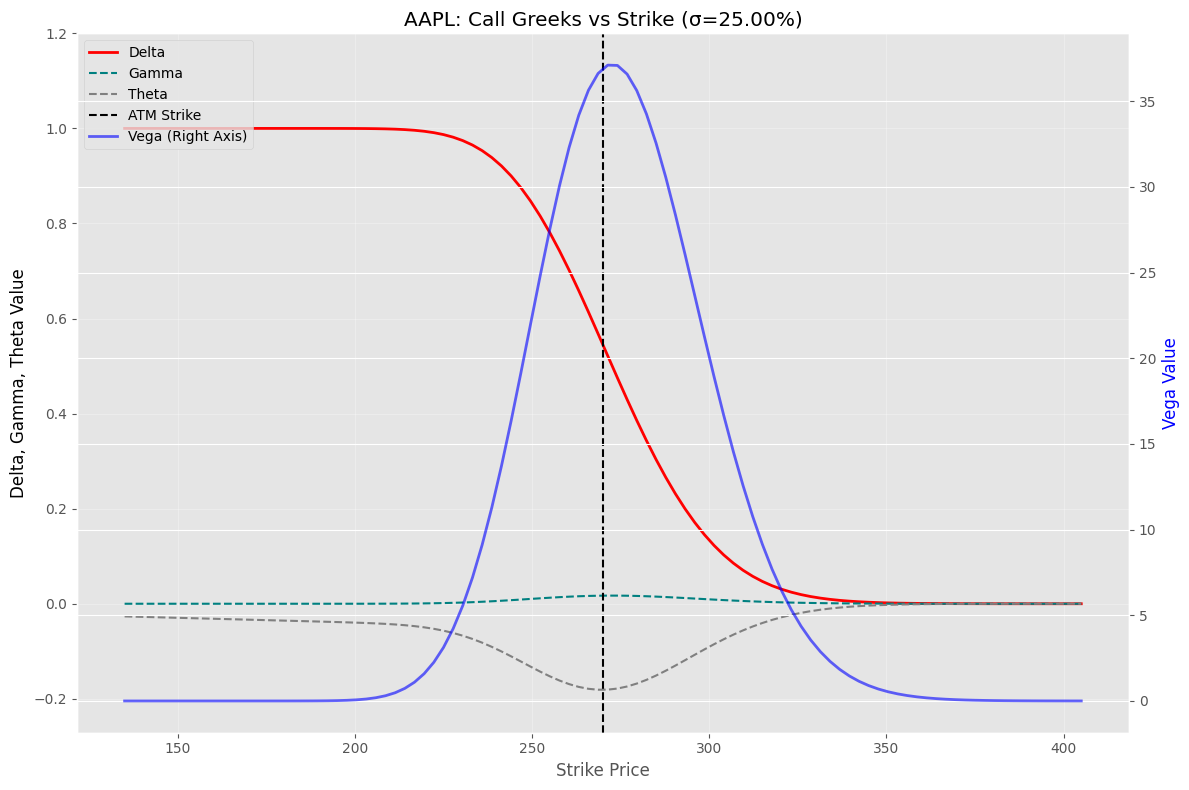

In [208]:

# ===========================================================================
# SECTION 15 : Plot Greeks
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats # Ensure scipy is imported for the norm functions

# --- Greeks Calculation Function (Requires stats.norm) ---
def calculate_greeks(S, K, T, r, sigma, option_type='call'):
    """Calculate option Greeks using Black-Scholes."""
    
    # Handle T=0 case to prevent division by zero
    if T <= 0:
        return {'delta': 1.0 if option_type == 'call' else 0.0, 
                'gamma': 0.0, 'vega': 0.0, 'theta': 0.0}
    
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Calculate phi(d1) - standard normal PDF
    phi_d1 = stats.norm.pdf(d1)
    
    # Calculate Greeks
    greeks = {
        # Delta: ranges from 0 to 1
        'delta': stats.norm.cdf(d1) if option_type == 'call' else stats.norm.cdf(d1) - 1,
        # Gamma: typically very small (e.g., 0.001 to 0.1)
        'gamma': phi_d1 / (S * sigma * np.sqrt(T)),
        # Vega: S * sqrt(T) * phi(d1). Can be large depending on S and T.
        'vega': S * np.sqrt(T) * phi_d1,
        # Theta: typically negative
        'theta': (-S * sigma * phi_d1 / (2 * np.sqrt(T)) -
                  r * K * np.exp(-r * T) * stats.norm.cdf(d2)) /252
    }

    return greeks

#Plotting Greeks
def plot_greeks_profile(S, T, r, sigma, option_type='call', ticker="TICKER"):
    # 1. Generate Greeks Data
    strikes = np.linspace(0.5 * S, 1.5 * S, 100)
    greeks_data = {k: [] for k in ['delta', 'gamma', 'vega', 'theta']}
    
    for K in strikes:
        g = calculate_greeks(S, K, T, r, sigma, option_type)
        for key in greeks_data:
            greeks_data[key].append(g[key])
            
    # Convert lists to NumPy arrays
    greeks_data = {k: np.array(v) for k, v in greeks_data.items()}

    # 2. Setup Plot
    plt.style.use('ggplot')
    fig, ax1 = plt.subplots(figsize=(12,8))

    # --- Plot 1: Delta, Gamma, Theta (Left Y-axis)
    ax1.plot(strikes, greeks_data['delta'], color='red', label='Delta', linewidth=2)
    ax1.plot(strikes, greeks_data['gamma'], color='teal', label='Gamma', linestyle='--')
    ax1.plot(strikes, greeks_data['theta'], color='gray', label='Theta', linestyle='--')

    ax1.axvline(S, color='k', linestyle='--', label='ATM Strike')
    ax1.set_xlabel("Strike Price")
    ax1.set_ylabel("Delta, Gamma, Theta Value", color='k')
    
    # Adjust limits for visual clarity of small Greeks
    max_delta = np.max(greeks_data['delta'])
    min_theta = np.min(greeks_data['theta'])
    ax1.set_ylim(min_theta * 1.5, max_delta * 1.2)


    # --- Plot 2: Vega (Right Y-axis) ---
    ax2 = ax1.twinx()
    ax2.plot(strikes, greeks_data['vega'], color='blue', label='Vega (Right Axis)', alpha=0.6, linewidth=2)
    ax2.set_ylabel("Vega Value", color='blue')
    
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    
    # Keep ATM Strike label from the first axis
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    ax1.set_title(f"{ticker}: {option_type.capitalize()} Greeks vs Strike (σ={sigma:.2%})")
    ax1.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_greeks_profile(S=270, T=30/252, r=0.05, sigma=0.25, ticker="AAPL")

In [217]:
# ===========================================================================
# SECTION 16 : DELTA HEDGING SIMULATION
# =============================================================================
def simulate_delta_hedging(S0, K, T, r, sigma, n_steps, rehedge_freq=1):
    """
    Simulate delta hedging of a short call position
    
    Strategy: Sell 1 call, hedge by buying delta shares of stock
    
    Parameters:
    -----------
    S0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to expiration (years)
    r : float
        Risk-free rate
    sigma : float
        Volatility
    n_steps : int
        Number of time steps
    rehedge_freq : int
        Rehedge every N steps (1 = daily)
    
    Returns:
    --------
    tuple : (final_pnl, results_dict)
    """
    dt = T / n_steps
    
    # Initialize arrays
    times = np.linspace(0, T, n_steps + 1)
    stock_prices = np.zeros(n_steps + 1)
    option_values = np.zeros(n_steps + 1)
    deltas = np.zeros(n_steps + 1)
    shares_held = np.zeros(n_steps + 1)
    cash_account = np.zeros(n_steps + 1)
    portfolio_values = np.zeros(n_steps + 1)
    
    # Initial setup
    stock_prices[0] = S0
    option_values[0] = black_scholes(S0, K, T, r, sigma, 'call')
    
    greeks = calculate_greeks(S0, K, T, r, sigma, 'call')
    deltas[0] = greeks['delta']
    
    # Sell the option (receive premium)
    cash_account[0] = option_values[0]
    
    # Buy delta shares to hedge
    shares_held[0] = deltas[0]
    cash_account[0] -= deltas[0] * S0
    
    # Portfolio value = cash + stock - short option
    portfolio_values[0] = cash_account[0] + shares_held[0] * S0 - option_values[0]
    
    # Simulate stock path (GBM)
    for i in range(1, n_steps + 1):
        time_remaining = T - times[i]
        
        # Stock price movement
        z = np.random.standard_normal()
        stock_prices[i] = stock_prices[i-1] * np.exp(
            (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z
        )
        
        # Rehedge?
        if i % rehedge_freq == 0 and time_remaining > 0:
            # Calculate new delta
            greeks = calculate_greeks(stock_prices[i], K, time_remaining, r, sigma, 'call')
            new_delta = greeks['delta']
            
            # Rebalance shares
            delta_change = new_delta - shares_held[i-1]
            shares_held[i] = new_delta
            cash_account[i] = cash_account[i-1] - delta_change * stock_prices[i]
            
            deltas[i] = new_delta
        else:
            # Keep same position
            shares_held[i] = shares_held[i-1]
            cash_account[i] = cash_account[i-1]
            deltas[i] = deltas[i-1]
        
        # Option value
        if time_remaining > 0:
            option_values[i] = black_scholes(stock_prices[i], K, time_remaining, r, sigma, 'call')
        else:
            option_values[i] = max(0, stock_prices[i] - K)
        
        # Portfolio value
        portfolio_values[i] = (cash_account[i] + 
                                shares_held[i] * stock_prices[i] - 
                                option_values[i])
    
    final_pnl = portfolio_values[-1]
    
    results = {
        'times': times,
        'stock_prices': stock_prices,
        'option_values': option_values,
        'deltas': deltas,
        'shares_held': shares_held,
        'cash_account': cash_account,
        'portfolio_values': portfolio_values,
        'final_pnl': final_pnl
    }
    
    return final_pnl, results

# Run single simulation
pnl, sim_results = simulate_delta_hedging(
    S0=current_price, K=current_price, T=1.0, r=0.05, sigma=0.20,
    n_steps=252, rehedge_freq=1
)

print(f"\n✅ Delta Hedging Simulation:")
print(f"   Final P&L: ${pnl:.2f}")
print(f"   Final stock price: ${sim_results['stock_prices'][-1]:.2f}")
print(f"   Option payoff: ${sim_results['option_values'][-1]:.2f}")


✅ Delta Hedging Simulation:
   Final P&L: $10.07
   Final stock price: $313.19
   Option payoff: $44.72


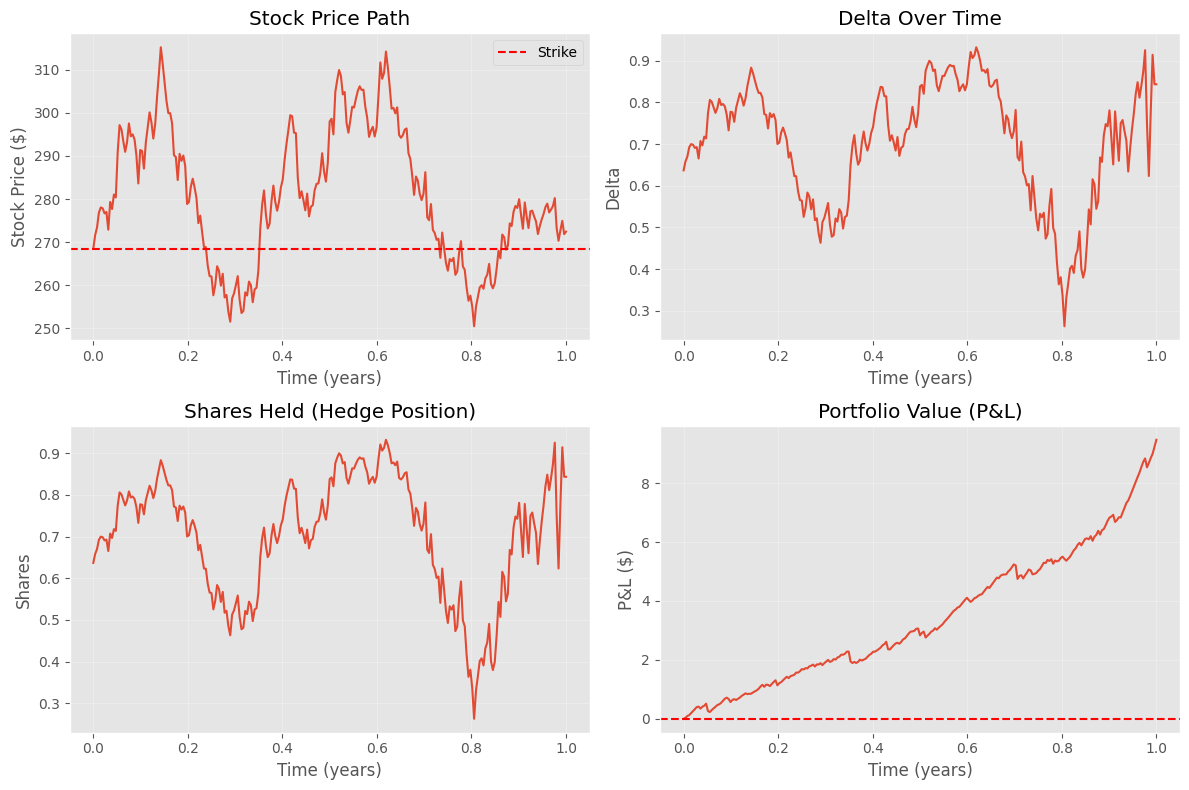

In [213]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Stock price path
axes[0, 0].plot(sim_results['times'], sim_results['stock_prices'])
axes[0, 0].axhline(current_price, color='r', linestyle='--', label='Strike')
axes[0, 0].set_title('Stock Price Path')
axes[0, 0].set_xlabel('Time (years)')
axes[0, 0].set_ylabel('Stock Price ($)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Delta over time
axes[0, 1].plot(sim_results['times'], sim_results['deltas'])
axes[0, 1].set_title('Delta Over Time')
axes[0, 1].set_xlabel('Time (years)')
axes[0, 1].set_ylabel('Delta')
axes[0, 1].grid(True, alpha=0.3)

# Shares held
axes[1, 0].plot(sim_results['times'], sim_results['shares_held'])
axes[1, 0].set_title('Shares Held (Hedge Position)')
axes[1, 0].set_xlabel('Time (years)')
axes[1, 0].set_ylabel('Shares')
axes[1, 0].grid(True, alpha=0.3)

# Portfolio value (P&L)
axes[1, 1].plot(sim_results['times'], sim_results['portfolio_values'])
axes[1, 1].axhline(0, color='r', linestyle='--')
axes[1, 1].set_title('Portfolio Value (P&L)')
axes[1, 1].set_xlabel('Time (years)')
axes[1, 1].set_ylabel('P&L ($)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('delta_hedging_simulation.png', dpi=300)
plt.show()

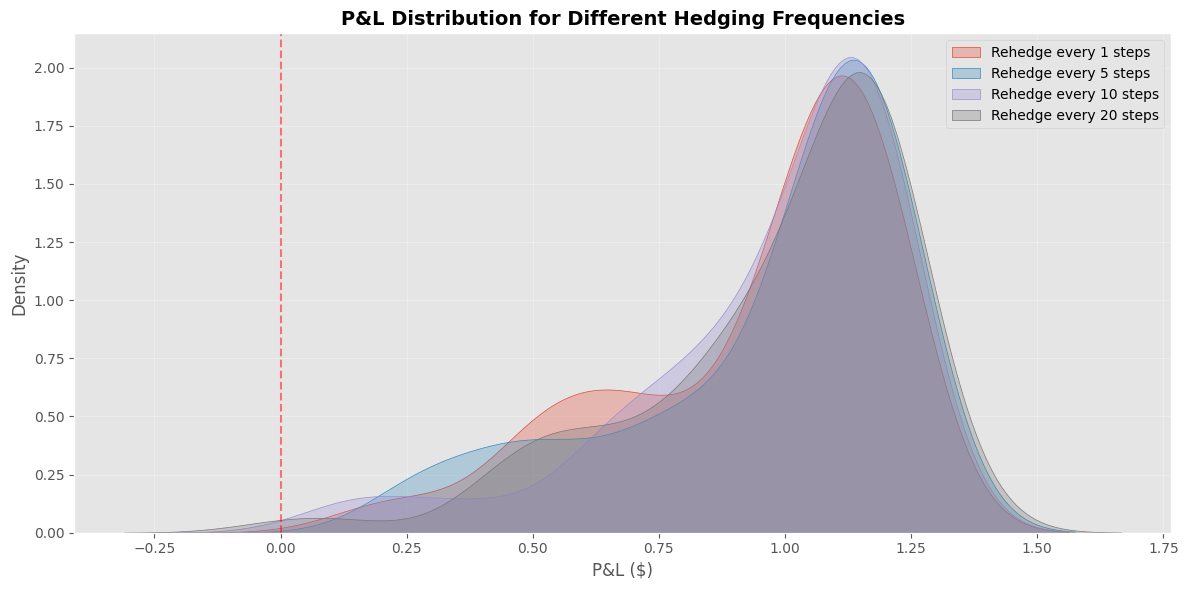


📊 HEDGING FREQUENCY ANALYSIS:

Rehedge every 1 steps:
   Mean P&L: $   0.95
   Std Dev:  $   0.27
   Min P&L:  $   0.16
   Max P&L:  $   1.24

Rehedge every 5 steps:
   Mean P&L: $   0.97
   Std Dev:  $   0.28
   Min P&L:  $   0.26
   Max P&L:  $   1.24

Rehedge every 10 steps:
   Mean P&L: $   0.97
   Std Dev:  $   0.26
   Min P&L:  $   0.09
   Max P&L:  $   1.24

Rehedge every 20 steps:
   Mean P&L: $   0.99
   Std Dev:  $   0.27
   Min P&L:  $   0.01
   Max P&L:  $   1.35


In [219]:
# ===========================================================================
# SECTION 17 : ANALYZE HEDGING FREQUENCY IMPACT
# =============================================================================
def analyze_hedging_performance(S0, K, T, r, sigma, n_sims=100, 
                                rehedge_frequencies=[1, 5, 10, 20]):
    """
    Analyze how hedging frequency affects performance
    
    Parameters:
    -----------
    S0, K, T, r, sigma : float
        Option parameters
    n_sims : int
        Number of simulations
    rehedge_frequencies : list
        List of rehedge frequencies to test
    """
    results = {}
    
    for freq in rehedge_frequencies:
        pnls = []
        for _ in range(n_sims):
            pnl, _ = simulate_delta_hedging(
                S0, K, T, r, sigma, n_steps=252, rehedge_freq=freq
            )
            pnls.append(pnl)
        
        results[freq] = {
            'pnls': pnls,
            'mean': np.mean(pnls),
            'std': np.std(pnls),
            'min': np.min(pnls),
            'max': np.max(pnls)
        }
    
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for freq, stats in results.items():
        sns.kdeplot(stats['pnls'], label=f'Rehedge every {freq} steps', fill=True, alpha=0.3)
    
    ax.set_title('P&L Distribution for Different Hedging Frequencies', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('P&L ($)', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.axvline(0, color='red', linestyle='--', alpha=0.5)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    # plt.savefig('hedging_frequency_analysis.png', dpi=300)
    plt.show()
    
    # Print statistics
    print("\n📊 HEDGING FREQUENCY ANALYSIS:")
    print("=" * 70)
    for freq, stats in results.items():
        print(f"\nRehedge every {freq} steps:")
        print(f"   Mean P&L: ${stats['mean']:7.2f}")
        print(f"   Std Dev:  ${stats['std']:7.2f}")
        print(f"   Min P&L:  ${stats['min']:7.2f}")
        print(f"   Max P&L:  ${stats['max']:7.2f}")

# Run analysis
analyze_hedging_performance(
    S0=current_price, K=current_price, T=30/252,
    r=RISK_FREE_RATE, sigma=atm_iv, n_sims=100
)

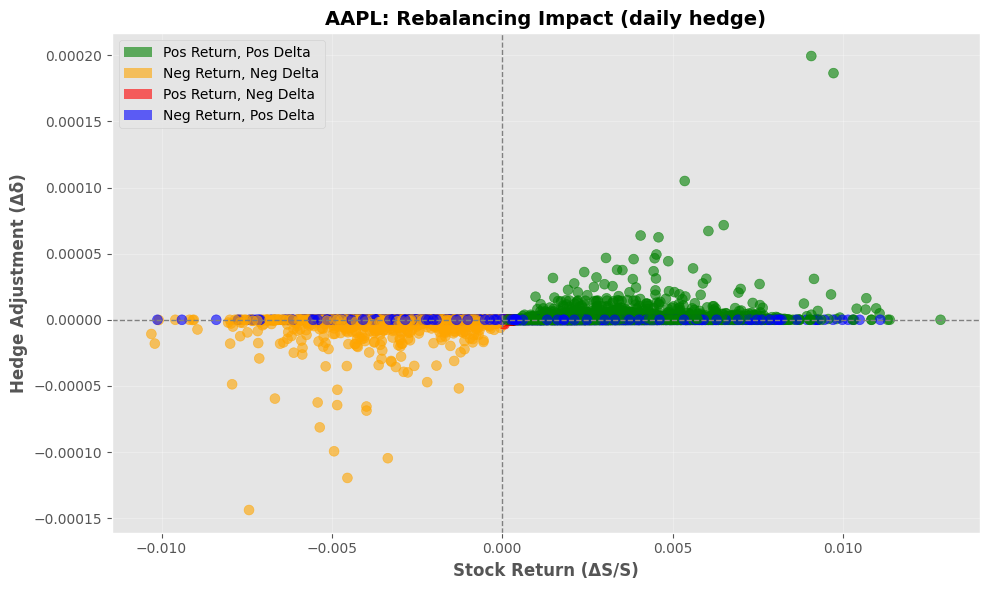


✅ Generated rebalancing impact plot
   Total rebalancing events: 12550
   Green quadrant: 5473
   Orange quadrant: 3458


In [220]:
# ===========================================================================
# SECTION 18 : ReBALANCING IMPACT VISUALIZATION
# =============================================================================
def plot_rebalancing_impact(S0, K, T, r, sigma, n_sims=100, rehedge_freq=1):
    """
    Generate rebalancing impact scatter plot
    Shows relationship between stock returns and delta adjustments
    """
    stock_returns = []
    delta_adjustments = []
    
    for _ in range(n_sims):
        # Run simulation
        _, results = simulate_delta_hedging(
            S0, K, T, r, sigma, n_steps=252, rehedge_freq=rehedge_freq
        )
        
        stock_path = results['stock_prices']
        deltas = results['deltas']
        
        # Extract rebalancing events
        for i in range(rehedge_freq, len(stock_path), rehedge_freq):
            if i < len(stock_path) - 1:  # Not at expiration
                # Stock return since last rebalance
                prev_price = stock_path[i - rehedge_freq]
                curr_price = stock_path[i]
                stock_ret = (curr_price - prev_price) / prev_price
                
                # Delta adjustment
                prev_delta = deltas[i - rehedge_freq]
                curr_delta = deltas[i]
                delta_adj = curr_delta - prev_delta
                
                stock_returns.append(stock_ret)
                delta_adjustments.append(delta_adj)
    
    # Create scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Color by quadrant
    colors = []
    for ret, adj in zip(stock_returns, delta_adjustments):
        if ret > 0 and adj > 0:
            colors.append('green')
        elif ret < 0 and adj < 0:
            colors.append('orange')
        elif ret > 0 and adj < 0:
            colors.append('red')
        else:
            colors.append('blue')
    
    ax.scatter(stock_returns, delta_adjustments, c=colors, alpha=0.6, s=50)
    
    # Reference lines
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.axvline(0, color='gray', linestyle='--', linewidth=1)
    
    # Labels
    ax.set_xlabel('Stock Return (ΔS/S)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Hedge Adjustment (Δδ)', fontsize=12, fontweight='bold')
    ax.set_title(f'{TICKER}: Rebalancing Impact (daily hedge)', 
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Create legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.6, label='Pos Return, Pos Delta'),
        Patch(facecolor='orange', alpha=0.6, label='Neg Return, Neg Delta'),
        Patch(facecolor='red', alpha=0.6, label='Pos Return, Neg Delta'),
        Patch(facecolor='blue', alpha=0.6, label='Neg Return, Pos Delta')
    ]
    ax.legend(handles=legend_elements, loc='best')
    
    plt.tight_layout()
    plt.savefig('rebalancing_impact.png', dpi=300)
    plt.show()
    
    print(f"\n✅ Generated rebalancing impact plot")
    print(f"   Total rebalancing events: {len(stock_returns)}")
    print(f"   Green quadrant: {sum(1 for c in colors if c == 'green')}")
    print(f"   Orange quadrant: {sum(1 for c in colors if c == 'orange')}")


# Generate the plot
plot_rebalancing_impact(
    S0=current_price,
    K=current_price,
    T=T_YEARS,
    r=RISK_FREE_RATE,
    sigma=atm_iv,
    n_sims=50,
    rehedge_freq=1
)

----***End of Project***----


**Experimental work :**


ANALYZING AAPL


/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/2957368916.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)


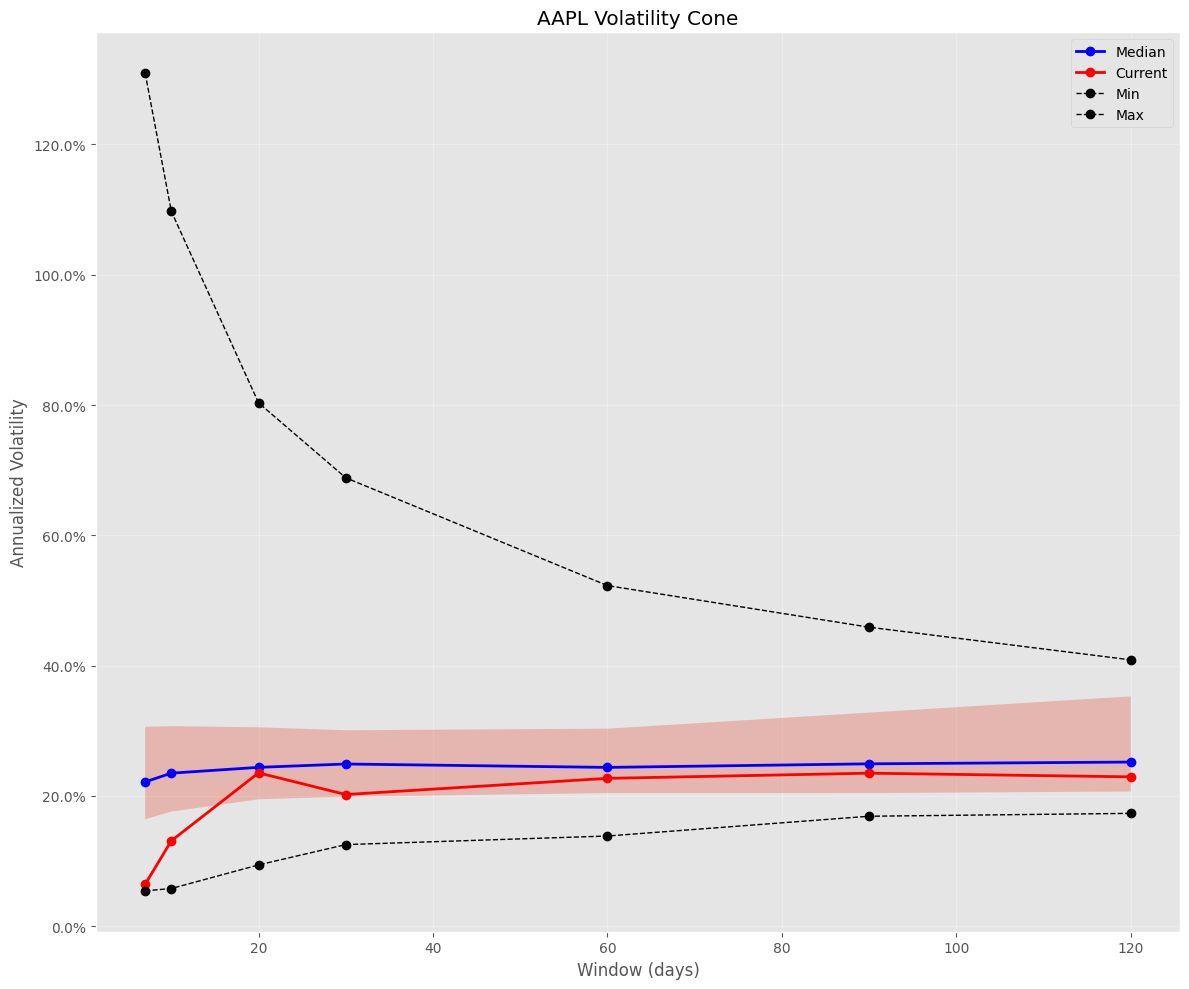


 Volatility cone plot saved!
Available expiration dates: ('2025-11-07', '2025-11-14', '2025-11-21')


/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/2491733414.py:33: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/2491733414.py:36: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)


ATM IV found for strike 270.0: 0.1155

Hedging Performance Summary: (rounded to 2 decimals)
                                                 pnls mean  std  min  max
1   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  NaN  NaN  NaN  NaN
5   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  NaN  NaN  NaN  NaN
10  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  NaN  NaN  NaN  NaN
20  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  NaN  NaN  NaN  NaN


/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/713015356.py:23: RuntimeWarning: invalid value encountered in sqrt
  (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * dW[i-1]
/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/2491733414.py:33: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/2491733414.py:36: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)
/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/3222758841.py:33: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(stats['pnls'], label=f'Rehedge every {freq} steps', fill=True)
/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/3222758841.py:33: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singul

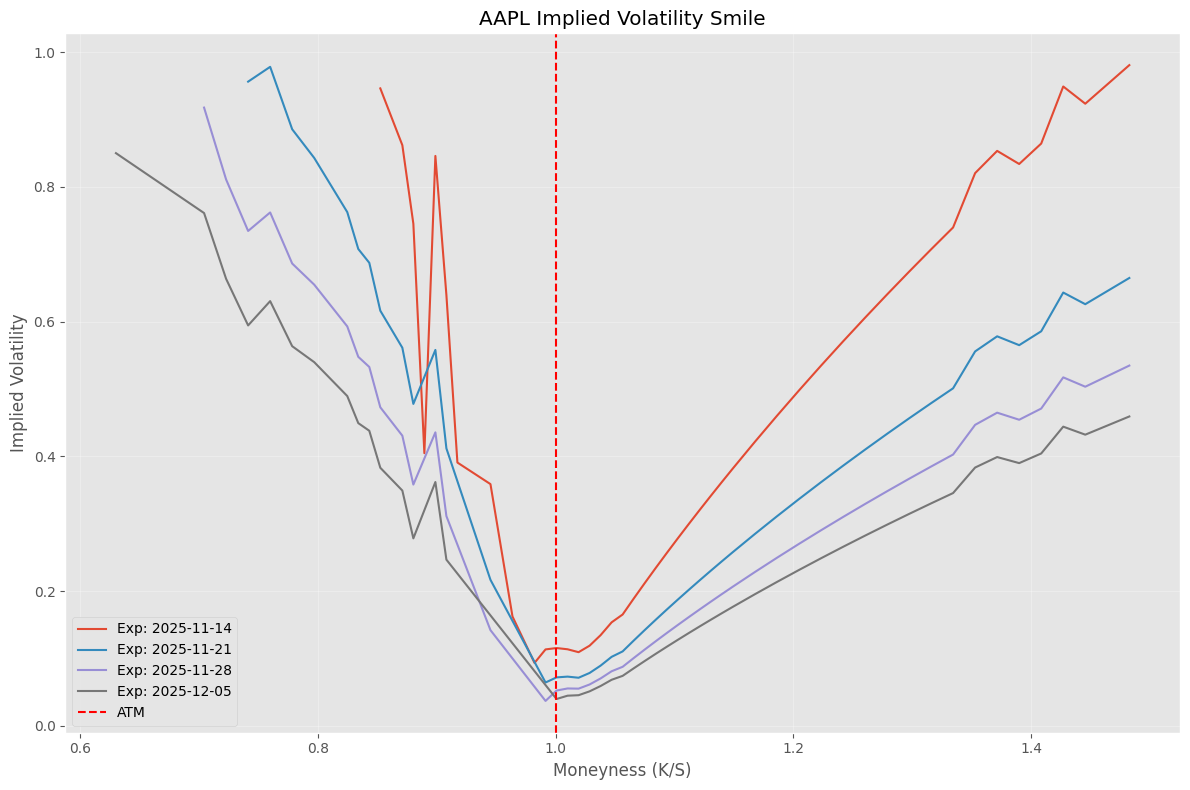

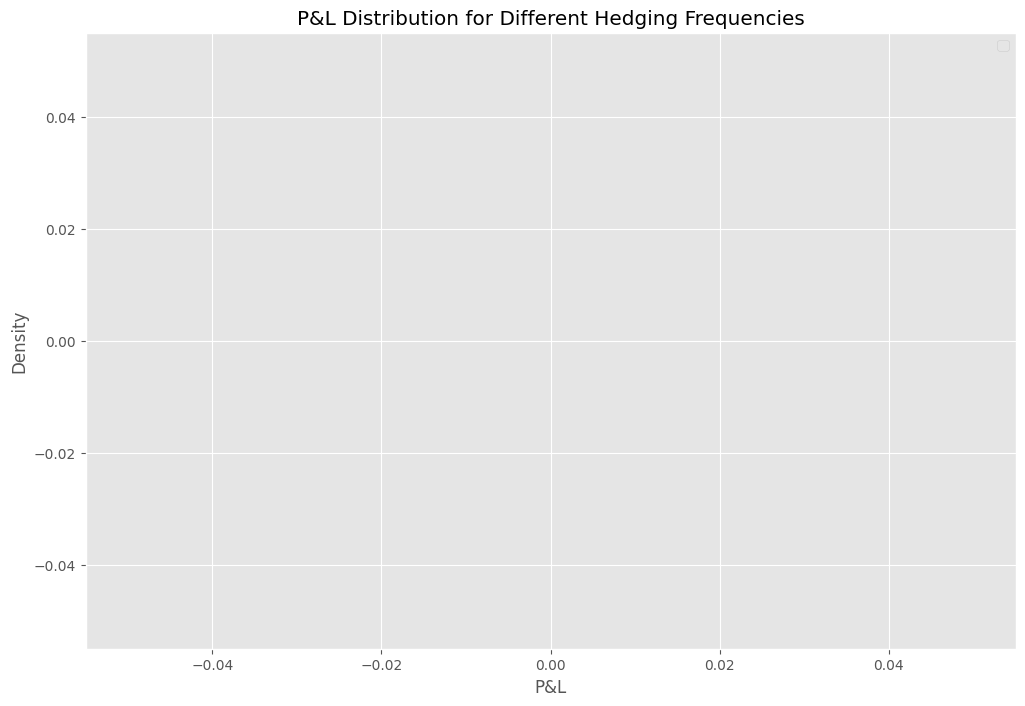


ANALYZING MSFT


/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/2957368916.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)


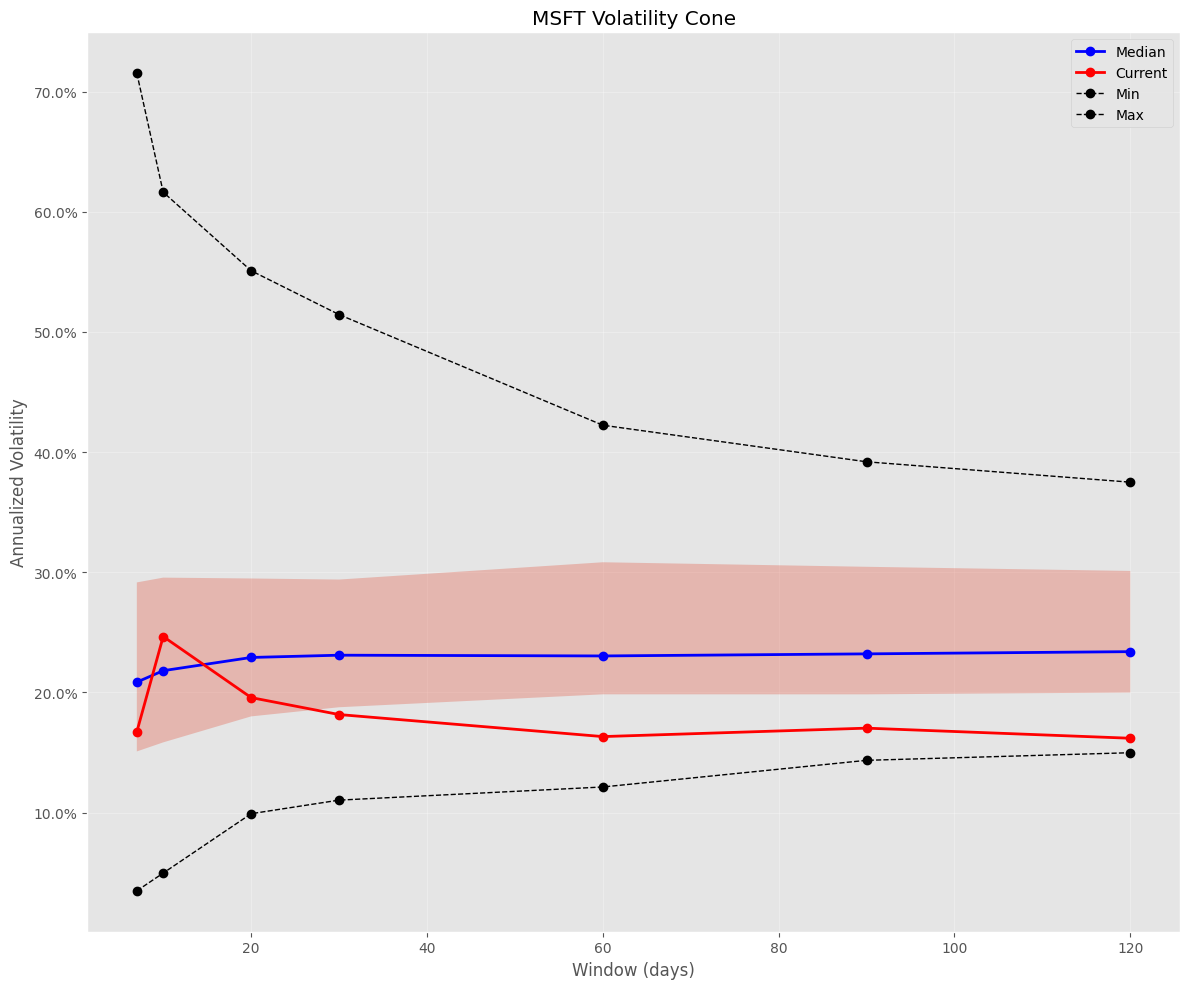


 Volatility cone plot saved!
Available expiration dates: ('2025-11-07', '2025-11-14', '2025-11-21')


/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/2491733414.py:33: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/2491733414.py:36: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)


ATM IV found for strike 497.5: 0.1060

Hedging Performance Summary: (rounded to 2 decimals)
                                                 pnls mean  std  min  max
1   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  NaN  NaN  NaN  NaN
5   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  NaN  NaN  NaN  NaN
10  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  NaN  NaN  NaN  NaN
20  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  NaN  NaN  NaN  NaN


/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/713015356.py:23: RuntimeWarning: invalid value encountered in sqrt
  (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * dW[i-1]
/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/2491733414.py:33: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/2491733414.py:36: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)
/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/3222758841.py:33: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(stats['pnls'], label=f'Rehedge every {freq} steps', fill=True)
/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/3222758841.py:33: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singul

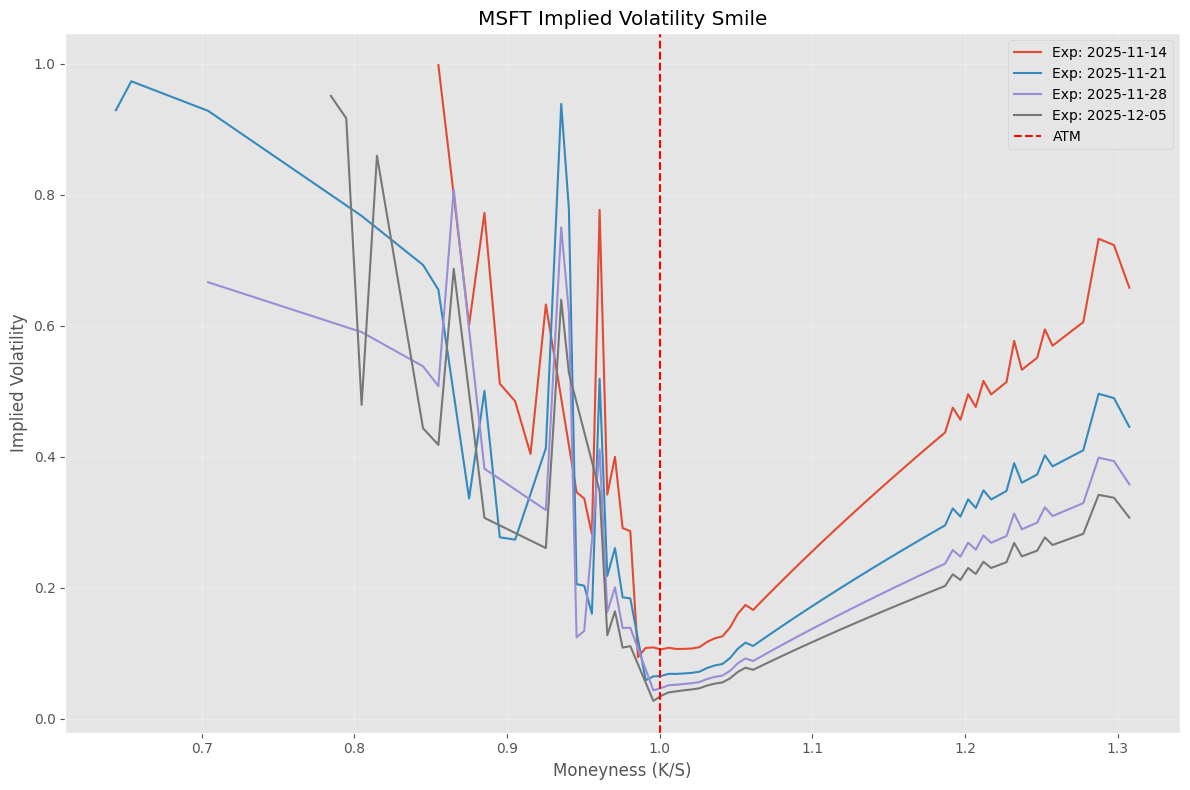

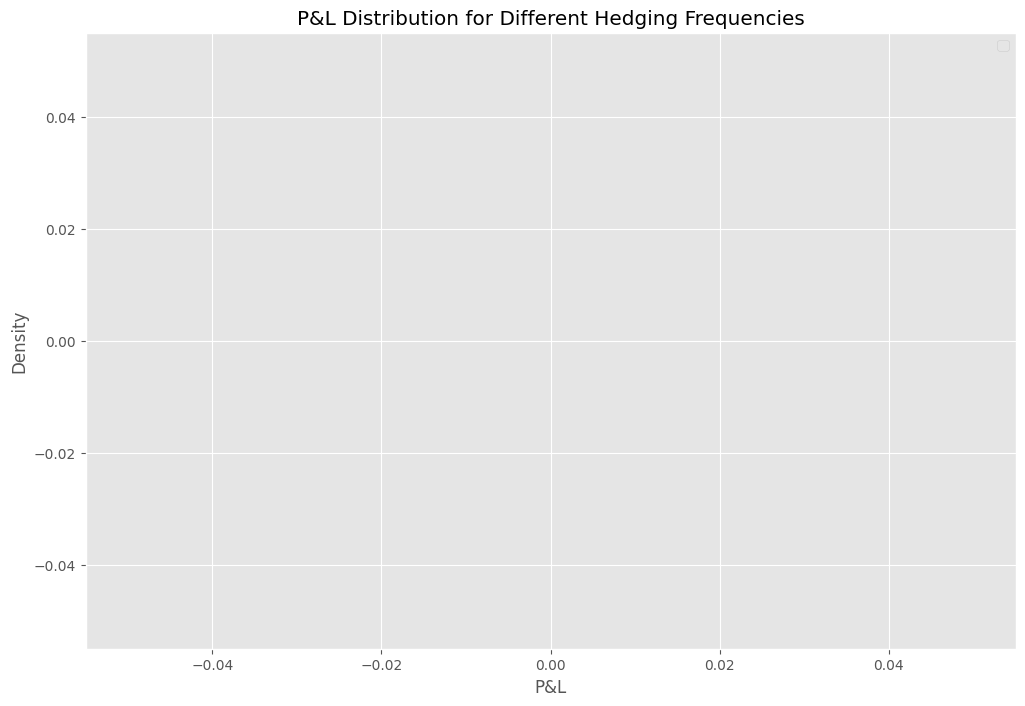

/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/2957368916.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)



ANALYZING GOOGL


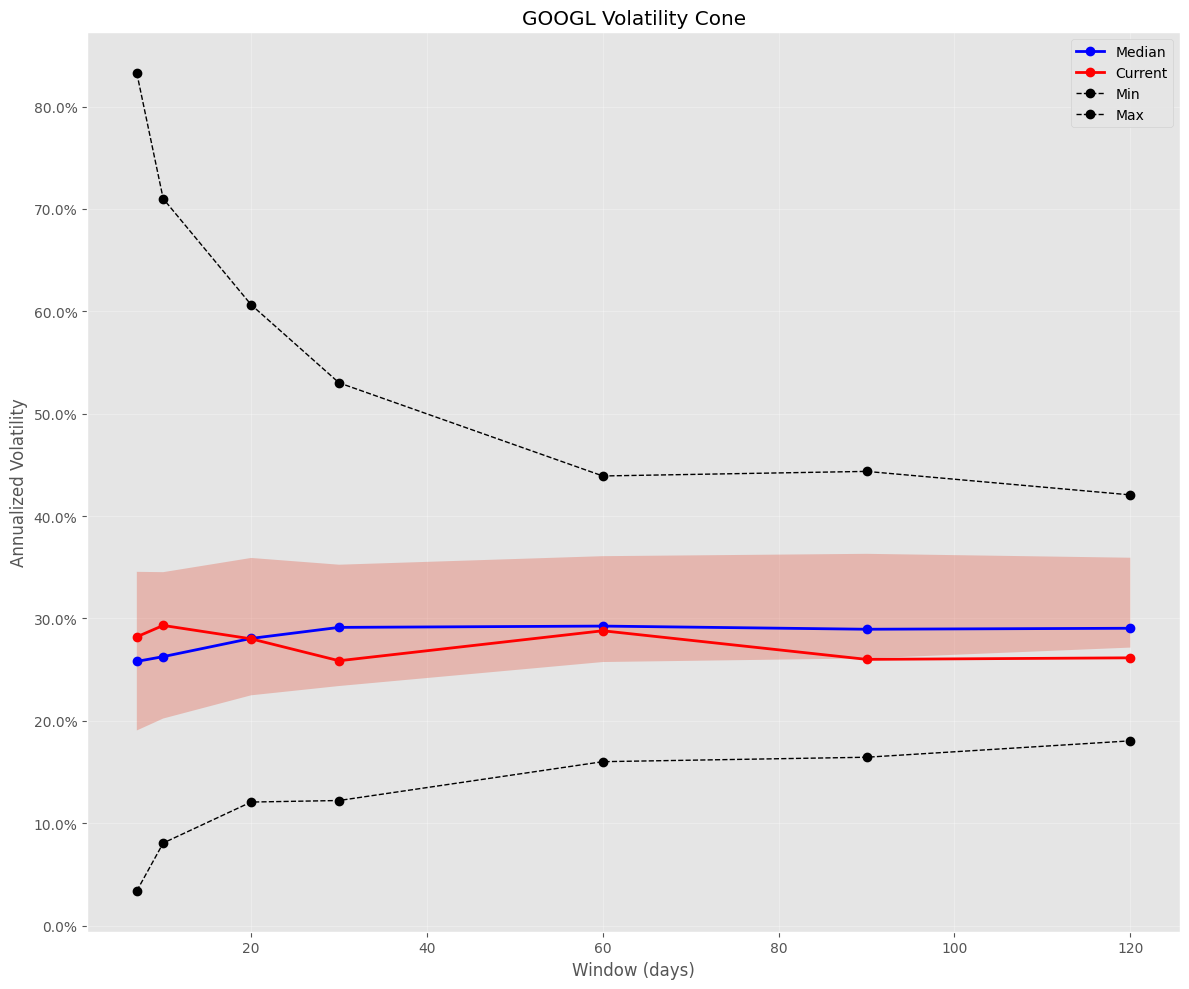


 Volatility cone plot saved!
Available expiration dates: ('2025-11-07', '2025-11-14', '2025-11-21')


/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/2491733414.py:33: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/2491733414.py:36: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)
/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/713015356.py:23: RuntimeWarning: invalid value encountered in sqrt
  (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * dW[i-1]
/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/2491733414.py:33: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/2491733414.py:36: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)
/var/folders/m5/w8bwgd4d4b98qr_spl9mxx8r0000gn/T/ipykernel_16850/3222758

ATM IV found for strike 285.0: 0.1447

Hedging Performance Summary: (rounded to 2 decimals)
                                                 pnls mean  std  min  max
1   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  NaN  NaN  NaN  NaN
5   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  NaN  NaN  NaN  NaN
10  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  NaN  NaN  NaN  NaN
20  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  NaN  NaN  NaN  NaN


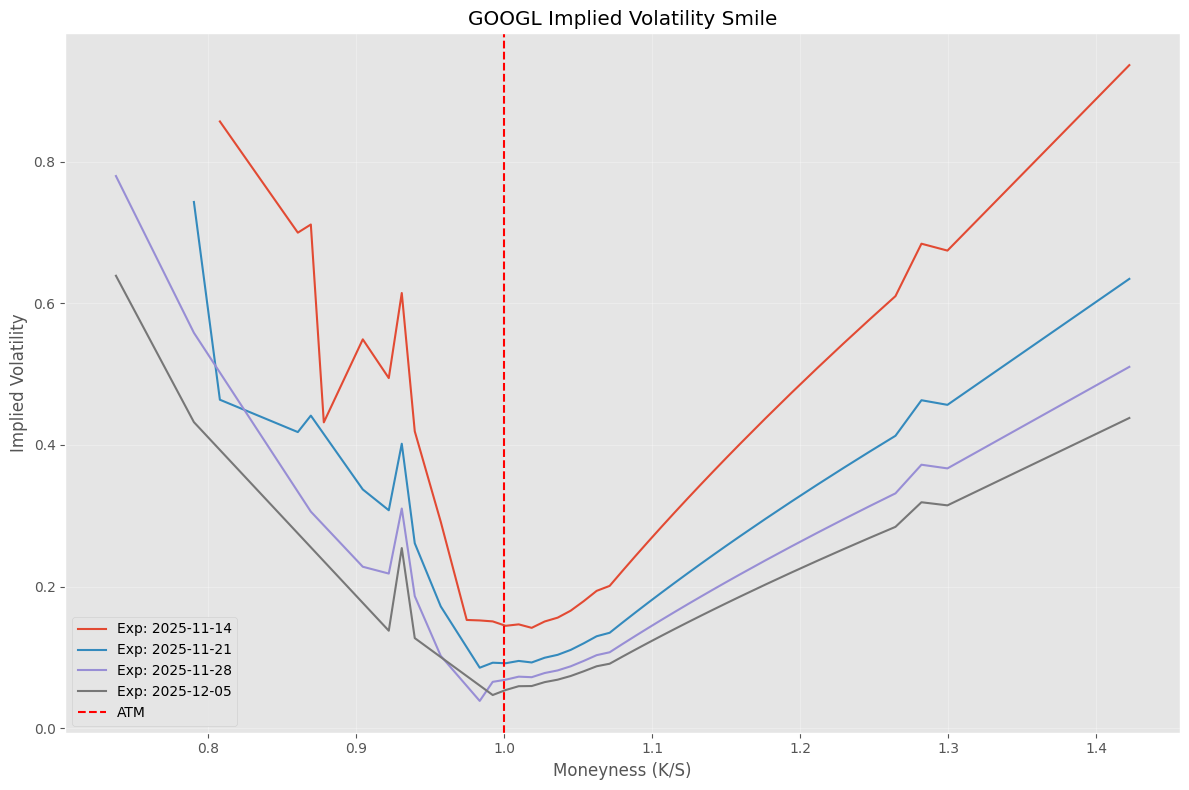

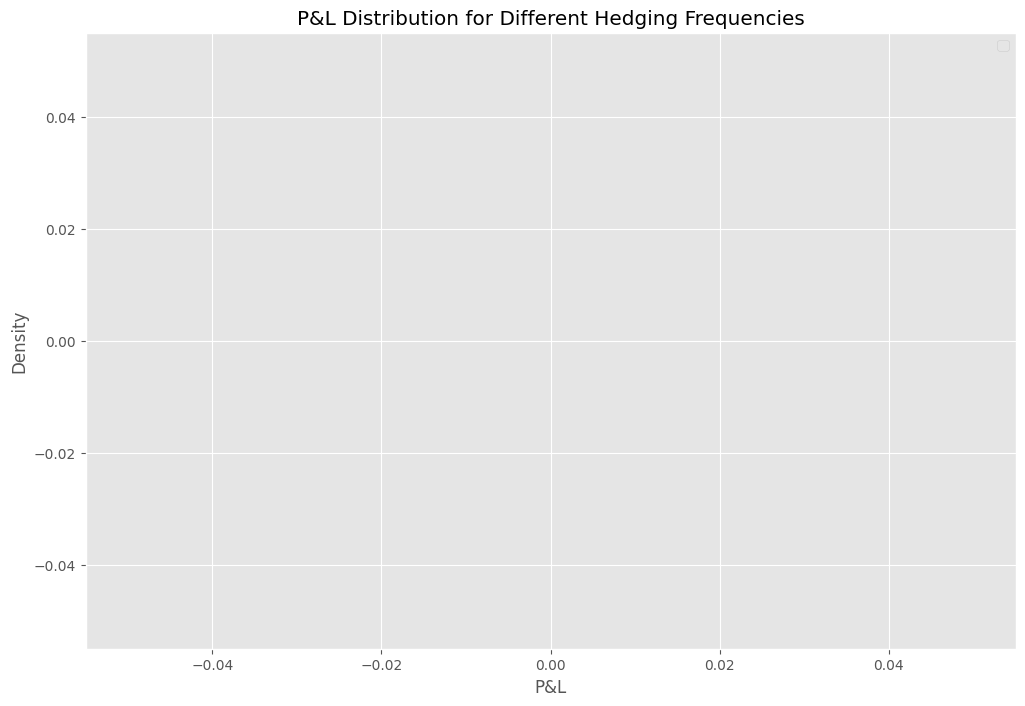

In [55]:
class VolatilityAnalyzer:
    def __init__(self, ticker, risk_free_rate, dividend_yield):
        self.ticker = ticker
        self.r = risk_free_rate
        self.q = dividend_yield
        
    def run_analysis(self, start_date, end_date):
        print(f"\n{'='*70}")
        print(f"ANALYZING {self.ticker}")
        print('='*70)
        
        # Phase 1
        self.stock_data = download_stock_data(self.ticker, start_date, end_date)
        returns = calculate_returns(self.stock_data['Close'])
        self.cone = build_volatility_cone(returns)
        plot_volatility_cone(self.cone, self.ticker)
        
        # Phase 2
        calls, puts, expirations, T_days, T_years = download_option_chain(self.ticker)
        current_price = get_current_price(self.ticker)
        
        iv_data = extract_implied_volatility(expirations, calls, puts, current_price)
        plot_volatility_smile(iv_data, current_price, self.ticker)
        
        # Phase 3
        self.atm_iv = get_atm_iv(iv_data, current_price)
        self.signals = generate_trading_signals(self.atm_iv, self.cone, window=30)
        
        # Phase 4
        analyze_hedging_performance(S0=current_price, K=current_price, T=T_years, 
                                   r=self.r, sigma=self.atm_iv, n_sims=100)
        
        return self

# Usage
tickers = ['AAPL', 'MSFT', 'GOOGL']
analyzers = {}

for ticker in tickers:
    analyzer = VolatilityAnalyzer(ticker, RISK_FREE_RATE, DIVIDEND_YIELD)
    analyzers[ticker] = analyzer.run_analysis(start_date, end_date)

In [ ]:
# print("=== DATA FOR SLIDES ===\n")

# # 1. Volatility Cone Stats (30-day window)
# cone_30 = cone[cone['window'] == 30].iloc[0]
# print("SLIDE 5: Volatility Cone")
# print(f"  Median: {cone_30['median']:.1%}")
# print(f"  25th percentile: {cone_30['25th']:.1%}")
# print(f"  75th percentile: {cone_30['75th']:.1%}")
# print(f"  Current: {cone_30['current']:.1%}")
# print(f"  Range: {cone_30['min']:.1%} - {cone_30['max']:.1%}")

# # 2. Trading Signals
# signals = generate_trading_signals(atm_iv, cone, window=30)

# print("\nSLIDE 6: Implied Volatility Analysis")
# print(f"  ATM IV: {signals['current_iv']:.1%}")
# print(f"  Signal: {signals['signal']}")
# print(f"  Level: {signals['level']}")
# print(f"  Reason: {signals['reason']}")

# # Calculate IV premium
# iv_premium = signals['current_iv'] - signals['historical_median']
# print(f"  IV premium: {iv_premium:.1%} ({iv_premium*100:.1f} percentage points)")

# # Calculate Z-score manually if not in signals
# hv_mean = cone_30['mean']
# hv_std = cone_30['std']
# z_score = (signals['current_iv'] - hv_mean) / hv_std
# print(f"  Z-score: {z_score:+.1f}σ")

# # Position relative to percentiles
# percentiles = signals['percentiles']
# if signals['current_iv'] > percentiles['75th']:
#     position = "Above 75th percentile"
# elif signals['current_iv'] > percentiles['median']:
#     position = "Between 50th-75th percentile"
# elif signals['current_iv'] > percentiles['25th']:
#     position = "Between 25th-50th percentile"
# else:
#     position = "Below 25th percentile"
# print(f"  Position: {position}")
